This is my second try, I thought rather than taking the previous 5 months taking the accident number in the previous years would give better result.

In [12]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import os

# This is the data preparation Part I explained this in the 'drawingGraph.ipynb' file
data =  pd.read_csv("monatszahlen2209_verkehrsunfaelle.csv")
data = data.iloc[:, :5] 
data.rename(columns={'MONATSZAHL': 'category'
                  , 'AUSPRÄGUNG': 'accidentType'
                  , 'JAHR': 'year'
                  , 'MONAT': 'month'
                  , 'WERT': 'value'}, inplace=True)
data = data[data["month"].str.lower() != "summe"]
data = data[data['accidentType'] == 'insgesamt']
data = data[data['category'] == 'Alkoholunfälle']
data['month'] = data['month'].apply(lambda x: int(str(x)[-2:]) if str(x).isdigit() else x)
data['Date'] = pd.to_datetime(data[['year', 'month']].assign(day=1)) #[day] is missing error was shown so I put the first day for each date 
toBeUsedForTesting = data #I will use this later for testing
data = data[data['year'] <= 2020].reset_index(drop=True) #because we will make predictions for 2021


In [3]:
# This is the model creation part I am using LSTM again
# Like the previous model I used dropout the prevent overfitting 
def create_model():
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, 5)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [4]:
# This is again like the previous model I am creating the previous steps and the 
# value that will be made predictions about
def dataset_creation(data, pre_steps):
    X, Y = [], []
    for i in range(len(data)-pre_steps-1):
        X.append(data[i:(i+pre_steps)])
        Y.append(data[i + pre_steps])
    return np.array(X), np.array(Y)

In [7]:
scalers = {} #  dictionary to hold trained minmax scaler objects. 
models = {} #  dictionary to hold trained model objects. 
data_per_month = dict() # dictionary to hold the data each month

for month in range(1, 13): # I am doing it for every month
    data_per_month[month] = data[(data['Date'].dt.month == month)].copy() # make the numbers equal to the current month index and be sure, copy is to be sure not to change the original data
    data_per_month[month].sort_values(by="Date", inplace=True) # sort the values
 
    scaler = MinMaxScaler(feature_range=(-1, 1)) # scaling the data to the range of -1 to 1
    data_per_month[month]['value'] = scaler.fit_transform(data_per_month[month]['value'].values.reshape(-1,1))
    
    scalers[month] = scaler #keep the scalers to unscale in the future

In [8]:
models = dict()  # Creating an empty dictionary to store separate models for each month
past_months = 5  # This is to give the previous 5 years' information to the model and creating 12 different model

for month in range(1, 13):  # Looping through each month of the year
    trainX, trainY = dataset_creation(data_per_month[month]['value'].values, past_months)  # Creating the dataset for the given month
    trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))  # Reshaping the input data to be in the form LSTM expects
    
    model = create_model()  # Creating the LSTM model
    model.fit(trainX, trainY, epochs=50, batch_size=4, verbose=2)  # Training the model on the data for the current month
    
    models[month] = model  # Storing the trained model for the current month in the dictionary

Epoch 1/50
4/4 - 2s - loss: 1.0112 - 2s/epoch - 521ms/step
Epoch 2/50
4/4 - 0s - loss: 0.8631 - 10ms/epoch - 3ms/step
Epoch 3/50
4/4 - 0s - loss: 0.8983 - 14ms/epoch - 4ms/step
Epoch 4/50
4/4 - 0s - loss: 0.7628 - 20ms/epoch - 5ms/step
Epoch 5/50
4/4 - 0s - loss: 0.7956 - 18ms/epoch - 4ms/step
Epoch 6/50
4/4 - 0s - loss: 0.8475 - 23ms/epoch - 6ms/step
Epoch 7/50
4/4 - 0s - loss: 0.8372 - 16ms/epoch - 4ms/step
Epoch 8/50
4/4 - 0s - loss: 0.6964 - 14ms/epoch - 3ms/step
Epoch 9/50
4/4 - 0s - loss: 0.6919 - 15ms/epoch - 4ms/step
Epoch 10/50
4/4 - 0s - loss: 0.7281 - 13ms/epoch - 3ms/step
Epoch 11/50
4/4 - 0s - loss: 0.6214 - 10ms/epoch - 3ms/step
Epoch 12/50
4/4 - 0s - loss: 0.6050 - 8ms/epoch - 2ms/step
Epoch 13/50
4/4 - 0s - loss: 0.5459 - 9ms/epoch - 2ms/step
Epoch 14/50
4/4 - 0s - loss: 0.6206 - 7ms/epoch - 2ms/step
Epoch 15/50
4/4 - 0s - loss: 0.4960 - 9ms/epoch - 2ms/step
Epoch 16/50
4/4 - 0s - loss: 0.5056 - 9ms/epoch - 2ms/step
Epoch 17/50
4/4 - 0s - loss: 0.4850 - 11ms/epoch - 3ms

In [10]:
def predict_accidents(year, month):  # Function to predict the number of accidents for a given year and month
    # Selecting the past_month data points for the input month and year
    data_to_predict = data_per_month[month][data_per_month[month]['year'] < year]['value'].values[-past_months:]
    data_to_predict = data_to_predict.reshape((1, 1, past_months))  # Reshaping the data to be in the form LSTM expects

    prediction = models[month].predict(data_to_predict)  # Making the prediction using the model for the given month
    prediction = scalers[month].inverse_transform(prediction)  # Inverting the scaling applied to the data to get the actual number of accidents
    
    return prediction 

1/1 [==============================] - 0s 22ms/step


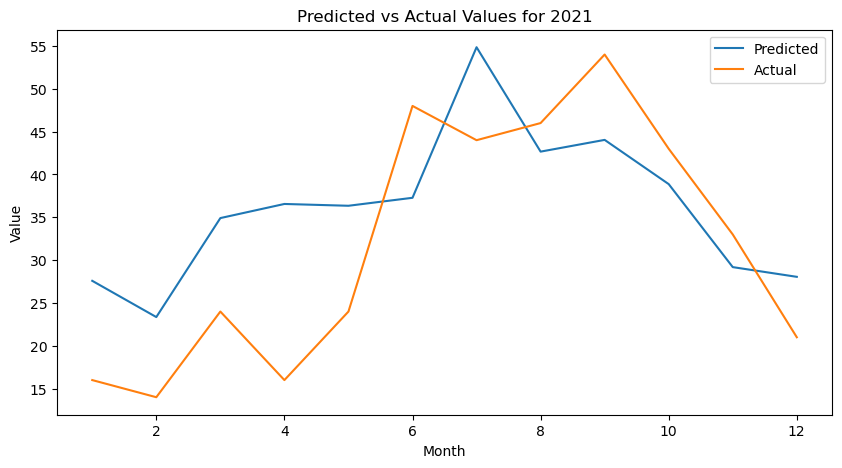

In [14]:
predictions = {}
actuals = {}

# Predicting the values for each month in 2021
for month in range(1, 13):
    prediction = predict_accidents(2021, month)
    actual = toBeUsedForTesting[(toBeUsedForTesting['Date'].dt.year == 2021) & (toBeUsedForTesting['Date'].dt.month == month)]['value'].values[0]
    predictions[month] = prediction.flatten()[0]  # flatten the prediction and take the first value
    actuals[month] = actual

# Plotting the predicted vs actual values for 2021
plt.figure(figsize=(10, 5))
plt.plot(list(predictions.keys()), list(predictions.values()), label='Predicted')
plt.plot(list(actuals.keys()), list(actuals.values()), label='Actual')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Predicted vs Actual Values for 2021')
plt.legend()
plt.show()

In [15]:
if not os.path.exists('models\model2'):  # Checking if the directory 'models1' exists
    os.makedirs('models\model2')  # Creating the directory if it doesn't exist

for month in range(1, 13):  # Looping through each month
    models[month].save(f"models\model2/model_{month}.h5")  # Saving the model for the current month
    joblib.dump(scalers[month], f'models\model2/scaler_{month}.pkl')  # Saving the scaler for the current month